In [13]:
import pandas as pd                 # Data tables
import os                           # Returns current directory, create files
import numpy as np                  # Arrays
import matplotlib.pyplot as plt	    # Graphs

from math import sqrt, atan, log

from scipy.integrate import odeint
from scipy.optimize import *
# import statsmodels.api as sm

# from pyomo.environ import *
# from pyomo.dae import *
# from pyomo.dae.simulator import Simulator

In [14]:
np.set_printoptions()  # formatter gets reset
np.set_printoptions(precision=2)
np.set_printoptions(linewidth=1000)

In [15]:
pi = np.pi

# DATA

In [16]:
# "! Proportion of radiative heat gains"
f_radiative = 0.5
f_rad       = min(1,max(0,f_radiative))

# "Average Specific mass per square meter of floor area"
M_per_A=150  # [kg/m^2] 
M_per_A_tot=max(10,M_per_A)

# "Wall mass accessibility "
iflag_suspended_ceiling = 1
iflag_raised_floor      = 0
iflag_carpet            = 0

if iflag_raised_floor==1 and iflag_carpet==1:
    iflag_carpet=0
    
# "Occupancy hours per day "
hour_start_occ=0  # [h]
hour_stop_occ=10  # [h]
hour_start_occupancy=min(24,max(0,hour_start_occ))
hour_stop_occupancy=min(24,max(0,hour_stop_occ))

# "Plant"
hour_start_plant=0 # [h]
hour_stop_plant=12 # [h]
hour_start_coolingplant=min(24,max(0,hour_start_plant))
hour_stop_coolingplant=min(24,max(0,hour_stop_plant))

In [17]:
# Infinitely long, directly opposed parallel plates of the same finite width.

def VF_para_inf(h,w):
    # h : Distance between plates
    # w : Width of the plates
    if w == 0:
        VF = 0
    else:
        HW = h/w
        VF = sqrt(1 + HW**2 ) - HW
    return VF

# Infinitely long, perpendicular plates, from plate 1 to plate 2.

def VF_per_inf(a1,a2):
    # a1 : Width of plate 1
    # a2 : Width of plate 2
    if a1 == 0:
        VF = 0
    else:
        HW = a2/a1
        VF = 1/2*(1 + HW - sqrt (1 + HW**2 ))
    return VF

# View factor parallel plates from 1 to 2 
#(Ref. Isidoro Martinez,"Radiative view Factors", p. 23 )

def BB(x,y,eta,xi,z):
    BB = ((y-eta)*sqrt((x-xi)**2+z**2)*atan((y-eta)/sqrt((x-xi)**2+z**2)) \
          +(x-xi)*sqrt((y-eta)**2+z**2)*atan((x-xi)/sqrt((y-eta)**2+z**2))-z**2/2*log((x-xi)**2+(y-eta)**2+z**2))
    return BB

# a1, b1, a2, b2 : half breadths (along x) and half lenghts (along y) of surfaces 1 and 2
# a0, b0 : coordinates of the center of surface 1 projected on surface 2, refering to surface 2 center
def VF_para(a1, b1, a2, b2, a0, b0, d):
        if d != 0 :
            z = d
            x = np.array([a0 - a1, a0 + a1])
            y = np.array([b0 - b1, b0 + b1])
            xi = np.array([- a2, a2])
            eta = np.array([- b2, b2])
            F = 0
            for i in range(2):
                for j in range(2):
                    for k in range(2):
                        for l in range(2):
                            F = F + ((-1)**(4+i+j+k+l)) * BB(x[i],y[j],eta[k],xi[l],z)
            A=(x[1]-x[0])*(y[1]-y[0])
            VF = F / (2 * pi * A)

        else:
            VF =0
        return VF

# View factor finite parallel plates same size
def VF_para_id(a,b,c):
    X = a/c
    Y = b/c
    VF = VF_para(a/2, b/2, a/2, b/2, 0, 0, c)
    return VF

# View factor perpendicular plates from 1 to 2 without offsets
def VF_per(a,b,c):
    if a != 0 and b != 0 and c != 0 :
        H=b/c
        W=a/c
        A=((1+W**2)*(1+H**2))/(1+W**2+H**2)
        B=((W**2*(1+W**2+H**2))/((1+W**2)*(W**2+H**2)))**(W**2)
        C=((H**2*(1+W**2+H**2))/((1+H**2)*(W**2+H**2)))**(H**2)
        VF=1/(pi*W)*(W*atan(1/W)+H*atan(1/H)-sqrt(H**2+W**2)*atan(1/sqrt(H**2+W**2))+ (1/4)* log(A*B*C))
    else:
        VF =0
    return VF

# View factor perpendicular plates from 1 to 2 with offsets
def VF_perp(a_1,a_2,b_1,b_2,c):
    A_1 = a_2*c
    A_13= (a_1+a_2)*c
    A_3 = a_1*c
    A_2 = b_2*c
    A_24= (b_1+b_2)*c
    A_4 = b_1*c
    if a_1 == 0 and  b_1 == 0:
        VF = VF_per(a_2,b_2,c)
    elif a_1 == 0:
        VF = VF_per(a_2,b_1+b_2,c) - VF_per(a_2,b_1,c)
    elif b_1 == 0:
        VF = (A_13*VF_per(a_1+a_2,b_2,c)-A_3*VF_per(a_1,b_2,c))/A_1
    else:
        VF=(A_13*VF_per(a_1+a_2,b_1+b_2,c)+A_3*VF_per(a_1,b_1,c) \
            -A_3*VF_per(a_1,b_1+b_2,c)-A_13*VF_per(a_1+a_2,b_1,c))/A_1
    return VF

# View factor between two not touching perpendicular rectangles from 1 to 2
def VF_perp_nt(a1, a2, b1, b2, c1, c2, c3):
# a1, a2, b1, b2, c1, c2, and  c3:  dimensions as shown in the figure.
# Martinez I., Radiation View Factors, 1995, p.27
    BB012345=VF_per((a1+a2),(b1+b2),(c1+c2+c3))*(a1+a2)*(c1+c2+c3)
    BB1234=VF_per((a1+a2),(b1+b2),(c1+c2))*(a1+a2)*(c1+c2)
    BB0145=VF_per((a1+a2),(b1+b2),(c2+c3))*(a1+a2)*(c2+c3)
    BB345=VF_per(a1,b1,(c1+c2+c3))*a1*(c1+c2+c3)
    B345_012345=VF_per(a1,(b1+b2),(c1+c2+c3))*a1*(c1+c2+c3)
    B012345_345=VF_per((a1+a2),b1,(c1+c2+c3))*(a1+a2)*(c1+c2+c3)
    B0145_45=VF_per((a1+a2),b1,(c2+c3))*(a1+a2)*(c2+c3)
    B1234_34=VF_per((a1+a2),b1,(c1+c2))*(a1+a2)*(c1+c2)
    B45_0145=VF_per(a1,(b1+b2),(c2+c3))*a1*(c2+c3)
    B34_1234=VF_per(a1,(b1+b2),(c1+c2))*a1*(c1+c2)
    BB14=VF_per((a1+a2),(b1+b2),c2)*(a1+a2)*c2
    B14_4=VF_per((a1+a2),b1,c2)*(a1+a2)*c2
    BB45=VF_per(a1,b1,(c2+c3))*a1*(c2+c3)
    BB34=VF_per(a1,b1,(c1+c2))*a1*(c1+c2)
    B4_14=VF_per(a1,(b1+b2),c2)*a1*c2
    BB4=VF_per(a1,b1,c2)*a1*c2
    VF=(BB012345-BB1234-BB0145+BB345-B345_012345-B012345_345+B0145_45+B1234_34+B45_0145+B34_1234+BB14-B14_4 \
        -BB45-BB34-B4_14+BB4)/(2*a2*c3)
    return VF

def View_factors(Lenght_6h_0h,Lenght_9h_3h,Height_room,Breadth_wd,Height_wd_sill,Height_wd):
    
    area_wd = Breadth_wd*Height_wd
    area_wall_0h = Lenght_9h_3h * Height_room - area_wd
    area_wall_3h = Lenght_6h_0h * Height_room
    area_wall_6h = Lenght_9h_3h * Height_room
    area_wall_9h = Lenght_6h_0h * Height_room
    area_ceiling = Lenght_6h_0h * Lenght_9h_3h
    area_floor = Lenght_6h_0h * Lenght_9h_3h
 
    # "! ComputeView factor from window to walls"
    x_1_wd=max(0,(Lenght_9h_3h-Breadth_wd)/2)
    x_2_wd=x_1_wd+Breadth_wd
    y_1_wd=Height_wd_sill
    y_2_wd=y_1_wd+Height_wd
 
    FV_wd_to_0h=0
    FV_0h_to_wd=0
 
#     FV_wd_to_6h=VF_para(Breadth_wd/2,Height_wd/2,Lenght_9h_3h/2,Height_room/2,0,0,Lenght_6h_0h)
#     FV_6h_to_wd=VF_para(Lenght_9h_3h/2,Height_room/2,Breadth_wd/2,Height_wd/2,0,0,Lenght_6h_0h)

    a = Height_wd/2 + Height_wd_sill - Height_room/2
    FV_wd_to_6h=VF_para(Breadth_wd/2,Height_wd/2,Lenght_9h_3h/2,Height_room/2,0,-a,Lenght_6h_0h)
    FV_6h_to_wd=VF_para(Lenght_9h_3h/2,Height_room/2,Breadth_wd/2,Height_wd/2,0,a,Lenght_6h_0h)
 
    FV_9h_to_wd_1=VF_perp(0,Lenght_6h_0h,x_1_wd,Breadth_wd,Height_wd)
    FV_9h_to_wd_2=VF_perp_nt(0.001,Lenght_6h_0h,x_1_wd,Breadth_wd,Height_wd,0.0001,y_1_wd)
    FV_9h_to_wd_3=VF_perp_nt(0.001,Lenght_6h_0h,x_1_wd,Breadth_wd,Height_wd,0.0001,Height_room-y_2_wd)
    FV_9h_to_wd=(Height_wd*FV_9h_to_wd_1+y_1_wd*FV_9h_to_wd_2+(Height_room-y_2_wd)*FV_9h_to_wd_3)/Height_room
 
    FV_wd_to_9h=FV_9h_to_wd*area_wall_9h/area_wd
 
    FV_3h_to_wd=FV_9h_to_wd
    FV_wd_to_3h=FV_wd_to_9h
 
    FV_ceiling_to_wd_1=VF_perp(0,Lenght_6h_0h,Height_room-y_2_wd,Height_wd,Breadth_wd)
    FV_ceiling_to_wd_2=VF_perp_nt(0.001,Lenght_6h_0h,Height_room-y_2_wd,Height_wd,Breadth_wd,0.0001,x_1_wd)
    FV_ceiling_to_wd=(Breadth_wd*FV_ceiling_to_wd_1+2*x_1_wd*FV_ceiling_to_wd_2)/Lenght_9h_3h
 
    FV_wd_to_ceiling=FV_ceiling_to_wd*area_ceiling/area_wd
 
    FV_floor_to_wd_1=VF_perp(0,Lenght_6h_0h,y_1_wd,Height_wd,Breadth_wd)
    FV_floor_to_wd_2=VF_perp_nt(0.001,Lenght_6h_0h,y_1_wd,Height_wd,Breadth_wd,0.0001,x_1_wd)
    FV_floor_to_wd=(Breadth_wd*FV_floor_to_wd_1+2*x_1_wd*FV_floor_to_wd_2)/Lenght_9h_3h
 
    FV_wd_to_floor=FV_floor_to_wd*area_floor/area_wd
 
    # "!Compute view factors from wall 1 to wall 2"
    # "Two opposite identical planes"
    FV_floor_to_ceiling=VF_para_id(Lenght_9h_3h,Lenght_6h_0h,Height_room)
    FV_ceiling_to_floor=FV_floor_to_ceiling
 
    # "Floor to vertical walls"
    FV_floor_to_3h=VF_per(Lenght_9h_3h,Height_room,Lenght_6h_0h)
    FV_3h_to_floor=VF_per(Height_room,Lenght_9h_3h,Lenght_6h_0h)
 
    FV_floor_to_6h=VF_per(Lenght_6h_0h,Height_room,Lenght_9h_3h)
    FV_6h_to_floor=VF_per(Height_room,Lenght_6h_0h,Lenght_9h_3h)

    FV_floor_to_9h=FV_floor_to_3h
    FV_9h_to_floor=FV_3h_to_floor
 
    # "Ceiling and floor: identical FV for walls"
    FV_ceiling_to_3h=FV_floor_to_3h
    FV_3h_to_ceiling=FV_3h_to_floor

    FV_ceiling_to_6h=FV_floor_to_6h
    FV_6h_to_ceiling=FV_6h_to_floor

    FV_ceiling_to_9h=FV_ceiling_to_3h
    FV_9h_to_ceiling=FV_3h_to_ceiling
 
    # "Wall to wall: facing walls"
    FV_3h_to_9h=VF_para_id(Lenght_6h_0h,Height_room,Lenght_9h_3h)
    FV_9h_to_3h=FV_3h_to_9h
 
    # "Wall to wall: corners"
    FV_6h_to_9h=VF_per(Lenght_9h_3h,Lenght_6h_0h,Height_room)
    FV_9h_to_6h=VF_per(Lenght_6h_0h,Lenght_9h_3h,Height_room)

    FV_6h_to_3h=FV_6h_to_9h
    FV_3h_to_6h=FV_9h_to_6h
 
    # "!Compute view factors of the wall 0h "
    FV_3h_to_0h=1-(FV_3h_to_wd+FV_3h_to_6h+FV_3h_to_9h+FV_3h_to_ceiling+FV_3h_to_floor)
    FV_6h_to_0h=1-(FV_6h_to_wd+FV_6h_to_3h+FV_6h_to_9h+FV_6h_to_ceiling+FV_6h_to_floor)
    FV_9h_to_0h=1-(FV_9h_to_wd+FV_9h_to_3h+FV_9h_to_6h+FV_9h_to_ceiling+FV_9h_to_floor)
    FV_ceiling_to_0h=1-(FV_ceiling_to_wd+FV_ceiling_to_3h+FV_ceiling_to_6h+FV_ceiling_to_9h+FV_ceiling_to_floor)
    FV_floor_to_0h=1-(FV_floor_to_wd+FV_floor_to_3h+FV_floor_to_6h+FV_floor_to_9h+FV_floor_to_ceiling)

    FV_0h_to_3h=FV_3h_to_0h*area_wall_3h/area_wall_0h
    FV_0h_to_6h=FV_6h_to_0h*area_wall_6h/area_wall_0h
    FV_0h_to_9h=FV_9h_to_0h*area_wall_9h/area_wall_0h
    FV_0h_to_ceiling=FV_ceiling_to_0h*area_ceiling/area_wall_0h
    FV_0h_to_floor=FV_floor_to_0h*area_floor/area_wall_0h
 
    # "!FV_wall(i,j) : View factor from the wall i to the wall j"
    FV_wall = np.array([[       0, FV_0h_to_3h, FV_0h_to_6h, FV_0h_to_9h, FV_0h_to_ceiling, FV_0h_to_floor], \
                      [FV_3h_to_0h,        0, FV_3h_to_6h, FV_3h_to_9h, FV_3h_to_ceiling, FV_3h_to_floor], \
                      [FV_6h_to_0h, FV_6h_to_3h,        0, FV_6h_to_9h, FV_6h_to_ceiling, FV_6h_to_floor], \
                      [FV_9h_to_0h, FV_9h_to_3h, FV_9h_to_6h,        0, FV_9h_to_ceiling, FV_9h_to_floor], \
                      [FV_ceiling_to_0h, FV_ceiling_to_3h, FV_ceiling_to_6h, FV_ceiling_to_9h,   0, FV_ceiling_to_floor], \
                      [  FV_floor_to_0h,   FV_floor_to_3h,   FV_floor_to_6h,   FV_floor_to_9h, FV_floor_to_ceiling, 0]])

    FV_to_wd = np.array([FV_0h_to_wd, FV_3h_to_wd, FV_6h_to_wd, FV_9h_to_wd, FV_ceiling_to_wd, FV_floor_to_wd])
    FV_wd_to = np.array([FV_wd_to_0h, FV_wd_to_3h, FV_wd_to_6h,  FV_wd_to_9h, FV_wd_to_ceiling, FV_wd_to_floor])

    return FV_wall,FV_to_wd,FV_wd_to

def wall_matrix(n_layers,thickness,lambdaval,rho,c_layer):
    
    #! n_div finite elements of order two by layer"
    n_div=2 # mandatory"
    n_elem=n_div*n_layers

    #! n_div finite elements of order two by layer#
    Res=thickness/lambdaval
    R_nobl=np.sum(Res)
    
    # Matrix lines and rows numbered from 1 to 2*n_elem+1 > at the end of the procedure suppress first row and first column

    #!Define coefficients of C (thermal mass) and L (conductivity) symetric matrixes #
    C_el = np.zeros((4,4))
    L_el = np.zeros((4,4))
    C_el[1,1]=2/15 ; C_el[2,2]=8/15 ; C_el[3,3]=2/15 ; C_el[2,1]=1/15 ;C_el[3,1]=-1/30 ; C_el[3,2]=1/15 
    L_el[1,1]=7/3 ; L_el[2,2]=16/3 ; L_el[3,3]=7/3 ; L_el[2,1]=-8/3 ;L_el[3,1]=1/3 ; L_el[3,2]=-8/3

    #! Define H matrix#
    #! Define vectors : RLE=lambda/epaisseur d'élément, RCE=rho*c_p*epaisseur d'élément#
    RLE0=lambdaval/(thickness/n_div)
    RCE0=rho*c_layer*thickness/n_div
    
    RLE= [0]
    RLE.extend(RLE0)
    RCE= [0]
    RCE.extend(RCE0)

    #!Define symetric matrixes M_1=L*deltaT/2+C and M_0=-L*deltaT/2+C   :#
    shape = (2*n_elem+2,2*n_elem+2)
    L = np.zeros(shape)
    C = np.zeros(shape)
    
    #Termes diagonaux extrêmes#
    L[1,1]= RLE[1]*L_el[1,1]
    C[1,1]= RCE[1]*C_el[1,1]

    L[2*n_elem+1,2*n_elem+1]=RLE[n_layers]*L_el[3,3]
    C[2*n_elem+1,2*n_elem+1]=RCE[n_layers]*C_el[3,3]

    #Termes diagonaux aux endroits de superpositions entre couches différentes#
    for k in range(1,n_layers):
        L[2*n_div*k+1,2*n_div*k+1]=RLE[k]*L_el[3,3]+RLE[k+1]*L_el[1,1]
        C[2*n_div*k+1,2*n_div*k+1]=RCE[k]*C_el[3,3]+RCE[k+1]*C_el[1,1]
   
    #Termes diagonaux aux endroits de superpositions entre mêmes matériaux
    #cette boucle ne fonctionne que pour n_div=2, sinon ajouter des lignes}
    for k in range(1,n_layers+1):
        L[2*n_div*k-1,2*n_div*k-1]=2*RLE[k]*L_el[3,3]
        C[2*n_div*k-1,2*n_div*k-1]=2*RCE[k]*C_el[3,3]

    #Sous-matrices des termes [2;1] [3;1] [2;2] [3;2]#
    for k in range(1,n_layers+1):
        #Première sous-couche i=1, seconde i=2#
        for i in range(1,n_div+1):
            #Terme diagonal#
            L[4*k+2*i-6+2,4*k+2*i-6+2]=RLE[k]*L_el[2,2]
            C[4*k+2*i-6+2,4*k+2*i-6+2]=RCE[k]*C_el[2,2]
            #Trois termes sous la diagonale#
            L[4*k+2*i-6+2,4*k+2*i-6+1]=RLE[k]*L_el[2,1]
            C[4*k+2*i-6+2,4*k+2*i-6+1]=RCE[k]*C_el[2,1]
            L[4*k+2*i-6+3,4*k+2*i-6+1]=RLE[k]*L_el[3,1]
            C[4*k+2*i-6+3,4*k+2*i-6+1]=RCE[k]*C_el[3,1]
            L[4*k+2*i-6+3,4*k+2*i-6+2]=RLE[k]*L_el[3,2]
            C[4*k+2*i-6+3,4*k+2*i-6+2]=RCE[k]*C_el[3,2]

    #Symetry#
    for i in range(1,n_elem*2+2):
        for j in range(1,i):
            L[j,i]=L[i,j]
            C[j,i]=C[i,j]
            
    L=L[1:,1:]
    C=C[1:,1:]

    return n_elem,R_nobl,L,C

def DELTAhour_start(hour_0,hour_start_0,hour_stop_0):
 
    if (hour_0==24):
        hour=0
    else:
        hour=hour_0
        
    if (hour_start_0==24):
        hour_start=0
    else:
        hour_start=hour_start_0
        
    if (hour_stop_0==24):
        hour_stop=0
    else:
        hour_stop=hour_stop_0

    #Checks whether an hour is in between a starting and a stopping hour ON THE CLOCK#
    # If so returns the number of hours from the starting hour#
    if (hour_start<hour_stop):
        if (hour>=hour_start) and (hour<=hour_stop):
            DELTAhour_start=hour-hour_start
        else:
            DELTAhour_start=0
    else:
        if ((hour>=hour_start) or (hour<=hour_stop)):
            if (hour>=hour_start):
                DELTAhour_start=hour-hour_start
            else:
                DELTAhour_start=24-hour_start+hour
        else:
            DELTAhour_start=0

    return DELTAhour_start


def plant(hour_per,hour_start,hour_stop,hour_start_occupancy):

    #DELTA_on=number of system working hours per day#
    if (hour_start<=hour_stop):
        DELTA_on=hour_stop-hour_start
    else:
        DELTA_on=24-hour_start+hour_stop

    if (DELTA_on<24):
        #! System intermittent working#
        #DELTAhour=number of hours from the start to the stop of the system#
        #DELTAhour > 0 means that hour_per is comprised between hour_start and hour_stop, ON THE CLOCK !#
        DELTAhour=DELTAhour_start(hour_per,hour_start,hour_stop)
        #DELTAhour_smooth=number of hours of smooth restart from the start of the system to the start of occupancy#
        #DELTAhour_smooth > 0 means that hour_per is comprised between hour_start and hour_start_occupancy, ON THE CLOCK !#
        DELTAhour_smooth=DELTAhour_start(hour_per,hour_start,hour_start_occupancy)
        #DELTAhour_restart=number of hours available to restart the system before occupancy#
        #DELTAhour_restart > 0 means that hour_start_occupancy is comprised between hour_start and hour_stop, ON THE CLOCK !#
        DELTAhour_restart=DELTAhour_start(hour_start_occupancy,hour_start,hour_stop)
        
        if (DELTAhour_restart >0) and (DELTAhour_smooth>0):
            # Smooth starting #
            plant = DELTAhour_smooth/DELTAhour_restart
        else:
            #On/off control#
#             if (DELTAhour > 0) or (hour_per==hour_start) or  ((hour_per==24) and (hour_start==0)):
            if (DELTAhour > 0) : 
                plant=1
            elif (DELTAhour_restart==0) and ((hour_per==hour_start) or  ((hour_per==24) and (hour_start==0))):
                plant=1
            else:
                plant=0

    else:
        #! System continous working#
        plant=1
 
    return plant


def occupancy(hour_0,hour_start_0,hour_stop_0):
 
    if (hour_0==24):
        hour=0
    else:
        hour=hour_0
    if (hour_start_0==24):
        hour_start=0
    else:
        hour_start=hour_start_0
    if (hour_stop_0==24):
        hour_stop=0
    else:
        hour_stop=hour_stop_0

    if (hour_start<hour_stop):
        if (hour>=hour_start) and (hour<=hour_stop):
            occupancy=1
        else:
            occupancy=0
    else:
        if ((hour>=hour_start) or (hour<=hour_stop)):
            occupancy=1
        else:
            occupancy=0

    return occupancy

In [18]:
# "Air properties:"
v_a=0.8401 # [m^3/kg] "specific volume of humid air per kg of dry air"
c_p_a=1020 # [J/kg-K] "specific heat capacity of humid air per kg of dry air"
sigma_boltzman=5.67E-8

# n_hours_per_day_plant=if(hour_start_coolingplant,hour_stop_coolingplant,hour_stop_coolingplant-hour_start_coolingplant,0,hour_start_coolingplant-hour_stop_coolingplant)
 
# "! Occupancy gains "
Q_dot_sensible_per_occ=90 # [W/occ]
# "Number of square meters of floor area per occupant"
n_occupants_per_area_floor=0 # [occ/m^2]
# "Lighting power per square meter of floor area"
Q_dot_light_per_area_floor=10 # [W/m^2]
# "Appliances power per square meter of floor area"
Q_dot_appliances_per_area_floor=0 # [W/m^2]
 
# "! Room Data"
# "Room height"
Height_room=2.7 # [m]
# "Lenght on 6h-0h direction"
Lenght_6h_0h=5.4 # [m]
# "Lenght on 9h-3h direction"
Lenght_9h_3h=1.8 # [m]
 
# "! Windows areas supposed to be included in 0h wall"
Height_wd=1.2 # [m]
Breadth_wd=1.6 # [m]
Height_wd_sill=0.8 #[m]
thickness_gl = 0.006 #[m]
 
# "! Windows parameters"
U_wd=1.49 # [W/m^2-K]
SF_gl=0.6
f_frame=0.3
rho_blind=0.64
rho_ground=0
slope_deg=90
 
# "!Boundary layers"
h_r=5 # [W/m^2-K]
h_c=3 # [W/m^2-K]
h_in=h_r + h_c
h_out=17 # [W/m^2-K]
 
# "!Outside insulation for external wall "
R_out= 2 # [m^2-K/W]
 
# "!Set points"
t_out=26 #[°C]
t_a_in_set=26 #[°C]
t_init=26 #[°C]
C_t_in=2 #[K^-1]
 
# "!Days of simulation"
n_day_sim=3

# "!Window area"
area_wd=Height_wd*Breadth_wd
SF_wd=(1-f_frame)*SF_gl
 
# "!Walls areas "
area_wall_0h=max(0,Height_room*Lenght_9h_3h-area_wd)
area_wall_3h=Height_room*Lenght_6h_0h
area_wall_6h=Height_room*Lenght_9h_3h
area_wall_9h=Height_room*Lenght_6h_0h
area_ceiling=Lenght_9h_3h*Lenght_6h_0h
area_floor=Lenght_9h_3h*Lenght_6h_0h

n_walls=6
area_wall = np.array([area_wall_0h, area_wall_3h, area_wall_6h, area_wall_9h, area_ceiling, area_floor])
area_wall_wd=np.sum(area_wall)+area_wd

#"! Estimated Floor Structure Mass and Wall Mass per square meter of area"
M_tot=max(100,area_floor*M_per_A_tot)
M_per_A_wall = M_tot/((area_wall[0]+np.sum(area_wall[1:4])/2)+2*(area_ceiling/2+area_floor/2))
M_per_A_floor=2*M_per_A_wall

# "! Cooling system sizing"
Q_dot_sensible_gains_max=area_floor* \
(n_occupants_per_area_floor*Q_dot_sensible_per_occ+Q_dot_light_per_area_floor+Q_dot_appliances_per_area_floor)
Q_dot_cooling_max=Q_dot_sensible_gains_max

#!Indoor air capacity"
C_a_in=5*Height_room*Lenght_6h_0h*Lenght_9h_3h*c_p_a/v_a

In [19]:
# glazing
rho_glazing=2500 #[kg/m^3]
lambda_glazing=1.0 #[W/m.K]
c_p_glazing=750 #[J/kg.K]

# concrete bloc
rho_concrete_bloc=1200 #[kg/m^3]
lambda_concrete_bloc=1.273 #[W/m.K]
c_p_concrete_bloc=840 #[J/kg.K]

# Hollow concrete 
rho_hollow_concrete=1600 #[kg/m^3]
lambda_hollow_concrete=1.182 #[W/m.K]
c_p_hollow_concrete=840 #[J/kg.K]

# plaster
e_suspended_ceiling=0.01 #[m]
lambda_suspended_ceiling=0.2 #[W/m.K]
rho_suspended_ceiling=1300 #[kg/m^3]
c_p_suspended_ceiling=840 #[J/kg.K]

# wood panel
e_raised_floor=0.02 #[m]
lambda_raised_floor=0.2 #[W/m.K]
rho_raised_floor=1600 #[kg/m^3]
c_p_raised_floor=800 #[J/kg.K]

# carpet
e_carpet=0.02 #[m]
lambda_carpet=0.2 #[W/m.K]
rho_carpet=1600 #[kg/m^3]
c_p_carpet=800 #[J/kg.K]

U_half_carpet = 2 * lambda_carpet/e_carpet

# Air layer
R_air_layer=0.17 #[m^2.K/W] #"0.17 for air +0.18 for insulation#"
U_air_layer=1/R_air_layer

thickness_air_layer=0.06#[m]
rho_air_layer=1.2 #[kg/m^3]
lambda_air_layer=thickness_air_layer/R_air_layer
c_p_air_layer=1060 #[J/kg.K]

In [20]:
# Glazing capacity"
C_gl = area_wd * (1-f_frame) * thickness_gl * rho_glazing * c_p_glazing

# Suspended ceiling"
C_A_ce = e_suspended_ceiling*rho_suspended_ceiling*c_p_suspended_ceiling
 
# Raised floor"
C_A_fl = e_raised_floor*rho_raised_floor*c_p_raised_floor

# Carpet"
C_A_cp = e_carpet*rho_carpet*c_p_carpet

In [21]:
# "!Total number of finite element layers, with two degree two elements by layer"
n_layers = 2
nl=n_layers

# "! internal vertical wall layers"
thickness_wall= (M_per_A_wall/2)/rho_concrete_bloc
thickness_wall_int= thickness_wall/n_layers * np.ones(n_layers) 
lambda_wall_int=  lambda_concrete_bloc * np.ones(n_layers)
rho_wall_int=  rho_concrete_bloc * np.ones(n_layers)
c_layer_wall_int= c_p_concrete_bloc * np.ones(n_layers)

# "! floor layers"
thickness_floor=(M_per_A_floor/2)/rho_hollow_concrete
thickness_floor_int= thickness_floor/n_layers * np.ones(n_layers)
lambda_floor_int=  lambda_hollow_concrete * np.ones(n_layers)
rho_floor_int=  rho_hollow_concrete * np.ones(n_layers)
c_layer_floor_int= c_p_hollow_concrete * np.ones(n_layers)

# Reverse arrays
thickness_floor_int_2 =thickness_floor_int[::-1]
lambda_floor_int_2 =lambda_floor_int[::-1]
rho_floor_int_2 =rho_floor_int[::-1]
c_layer_floor_int_2 =c_layer_floor_int[::-1]

In [22]:
# Matrixes of vertical wall layers"
n_elem,R_nobl_wall,L_wall,C_wall = wall_matrix(n_layers,thickness_wall_int,lambda_wall_int,rho_wall_int,c_layer_wall_int)
 
# Matrixes of floor layers"
n_elem,R_nobl_floor,L_floor,C_floor = wall_matrix(n_layers,thickness_floor_int,lambda_floor_int,rho_floor_int,c_layer_floor_int)

n_nodes=2*n_elem+1

In [23]:
shape = (n_walls, n_nodes, n_nodes)
C_matrix = np.zeros(shape) ; L_matrix = np.zeros(shape)

# External wall
C_matrix[0] = C_wall; L_matrix[0] = L_wall
# Internal walls
C_matrix[1] = C_wall; L_matrix[1] = L_wall
C_matrix[2] = C_wall; L_matrix[2] = L_wall
C_matrix[3] = C_wall; L_matrix[3] = L_wall
# Ceiling
C_matrix[4] = C_wall; L_matrix[4] = L_wall
# Floor
C_matrix[5] = C_floor; L_matrix[5] = L_floor

In [24]:
# "! ComputeView factor from walls to walls, from walls to window and from window to walls"
FV_wall,FV_to_wd,FV_wd_to = View_factors(Lenght_6h_0h,Lenght_9h_3h,Height_room,Breadth_wd,Height_wd_sill,Height_wd)

In [25]:
# Boundary layers"
Ah_c_wall=h_c*area_wall
Ah_r_wall_to_wd=h_r*area_wall*FV_to_wd
Ah_r_wd_to_wall=h_r*area_wd*FV_wd_to
Ah_r_wall=h_r*np.diag(area_wall) @ FV_wall

Ah_c_wd=area_wd*h_c
Ah_c_internal_blind=2*area_wd*h_c
Ah_r_wd_internal_blind=area_wd*h_r

#!Window"
R_wd_no_in_bl=max(0,1/U_wd-1/h_in)
U_wd_no_in_bl=1/R_wd_no_in_bl
AU_wd_no_in_bl=area_wd*U_wd_no_in_bl

In [26]:
# Initial conditions"
t_a_in_init=t_a_in_set
U_c_in_init=C_a_in*t_init
 
#simulation data"
n_hours_sim=24*n_day_sim
hour_start=0
hour_stop=hour_start+n_hours_sim
 
tau_initial=hour_start*3600
tau_final=hour_stop*3600
 
DELTAtau=600 #[s]
time_step=3600 #[s]

In [27]:
# Time in s
# Create an array of evenly-spaced values
tau = np.arange(tau_initial,tau_final+1,DELTAtau)

hour =tau/3600
hour_per_0=hour -24*np.trunc(hour/24)
# np.choose(condition,[action if condition = 0 or false, action if condition = 1 or true])
# np.choose(array, [action if condition = 0, action if condition = 1 , action if condition = 2 ...)])
hour_per=np.choose(hour_per_0 > 0.000001,[24,hour_per_0])

day=hour/24
day_num_0=np.trunc(hour/24)+1
day_num=day_num_0-1

In [30]:
# hour_start_occ=8  # [h]
# hour_stop_occ=18  # [h]
# hour_start_occupancy=min(24,max(0,hour_start_occ))
# hour_stop_occupancy=min(24,max(0,hour_stop_occ))

# hour_start_plant=6 # [h]
# hour_stop_plant=18 # [h]
# hour_start_coolingplant=min(24,max(0,hour_start_plant))
# hour_stop_coolingplant=min(24,max(0,hour_stop_plant))

#!Plant on/off#
#Smooth starting of the system when intermittent cooling is performed#
f_plant=np.asarray([plant(hi,hour_start_coolingplant,hour_stop_coolingplant,hour_start_occupancy) for hi in hour_per])

#!Occupancy heat gains#
f_gains=np.asarray([occupancy(hi,hour_start_occupancy,hour_stop_occupancy) for hi in hour_per])

In [31]:
# Heat gains
Q_dot_sensible_gains=f_gains*Q_dot_sensible_gains_max
 
#! Share internal heat gains into radiative and convective#
Q_dot_sensible_gains_rad=f_rad*Q_dot_sensible_gains   
Q_dot_sensible_gains_conv=(1-f_rad)*Q_dot_sensible_gains     

#! Radiative sensible heat gains shared as function of walls areas#

if area_wall_wd>0:
    Q_dot_rad_wall= np.asarray([np.asarray([x*y/area_wall_wd  for y in Q_dot_sensible_gains_rad]) for x in area_wall])
    Q_dot_rad_wd=Q_dot_sensible_gains_rad*area_wd/area_wall_wd
else:
    Q_dot_rad_wall= np.asarray([np.asarray([x*y*0  for y in Q_dot_sensible_gains_rad]) for x in area_wall])
    Q_dot_rad_wd= Q_dot_sensible_gains_rad*0

In [32]:
C_t_in = 2

tau_0  = tau[0]

t_a_in_0 = t_init
t_s_wd_0 = t_init
t_s_ce_0 = t_init
t_s_fl_0 = t_init
t_s_cp_0 = t_init

Ti0  = [t_a_in_0 ]
Ti0.extend([t_s_wd_0 ])
Ti0.extend([t_s_ce_0 ])
Ti0.extend([t_s_fl_0 ])
Ti0.extend([t_s_cp_0 ])
Ti0.extend(t_init * np.ones(n_nodes * n_walls))

Q_dot_cooling_v = []

t_a_in_set = 26.01

def model_dTi_t(Ti, tau):
    T1 = Ti[0]
    T2 = Ti[1]
    T3 = Ti[2]
    T4 = Ti[3]
    T5 = Ti[4]
    Tw = Ti[5:].reshape((n_walls, n_nodes))
    
    ind = int((tau - tau_0) /DELTAtau) 
    if ind>len(f_plant)-1: ind=len(f_plant)-1
             
    #Internal air capacity heat balance#
    t_a_in = T1
    
    if (C_t_in*(t_a_in-t_a_in_set) > 0 ) and (C_t_in*(t_a_in-t_a_in_set) < 1 ) :
        X_cooling=C_t_in*(t_a_in-t_a_in_set)
    elif C_t_in*(t_a_in-t_a_in_set) > 1 :
        X_cooling=1
    else:
        X_cooling=0

    Q_dot_cooling=f_plant[ind]*X_cooling*Q_dot_cooling_max
    Q_dot_cooling_v.append(tau)
    
    # Glazing temperature
    t_s_wd = T2
    
    # Suspended ceiling temperature
    t_s_ce = T3
    
    # Raised floor temperature
    t_s_fl = T4
    
    # Carpet temperature
    t_s_cp = T5
    
    # Radiative and convective heat exchanges between wall surfaces
    t_s_wall = Tw[:,0]
    
    if iflag_suspended_ceiling == 1 : t_s_wall[4] = t_s_ce
    if iflag_raised_floor == 1      : t_s_wall[5] = t_s_fl
    if iflag_carpet == 1            : t_s_wall[5] = t_s_cp
    
    #Wall surface nodes#
    Q_dot_r_i_to_j = np.diag(t_s_wall) @ Ah_r_wall - Ah_r_wall @ np.diag(t_s_wall)
    
    #Wall to indoor air convective exchanges#
    Q_dot_c_in_to_wall = Ah_c_wall*(t_a_in-t_s_wall)
    
    #Window heat balance#
    Q_dot_out_to_wd=AU_wd_no_in_bl*(t_out-t_s_wd)
    Q_dot_c_wd_to_in=Ah_c_wd*(t_s_wd-t_a_in)
    
    #wall to window radiative exchanges#
    Q_dot_r_wall_to_wd = Ah_r_wall_to_wd*(t_s_wall-t_s_wd)
    Q_dot_r_wd_to_wall = Ah_r_wd_to_wall*(t_s_wd-t_s_wall)
    
    # Wall surface node heat balance; Matrix Aij with axis=0 > sum on first index i i.e. sum of each column
    Q_dot_in_to_wall = Q_dot_r_wd_to_wall - Q_dot_r_wall_to_wd + Q_dot_rad_wall[:,ind] + Q_dot_c_in_to_wall+ \
    np.sum(Q_dot_r_i_to_j, axis=0) - np.sum(Q_dot_r_i_to_j, axis=1) 
    
    i1 = -Q_dot_cooling-np.sum(Q_dot_c_in_to_wall)+Q_dot_c_wd_to_in+Q_dot_sensible_gains_conv[ind]
    C1 = C_a_in
    dT1_t =  i1/C1
    
    i2 = Q_dot_out_to_wd+np.sum(Q_dot_r_wall_to_wd)+Q_dot_rad_wd[ind]-np.sum(Q_dot_r_wd_to_wall)-Q_dot_c_wd_to_in
    C2 = C_gl
    dT2_t =  i2/C2
    
    i3 = Q_dot_in_to_wall[4]/area_wall[4]
    C3 = C_A_ce
    dT3_t =  i3/C3
    
    i4 = Q_dot_in_to_wall[5]/area_wall[5]
    C4 = C_A_fl
    dT4_t =  i4/C4
    
    i5 = Q_dot_in_to_wall[5]/area_wall[5]
    C5 = C_A_cp
    dT5_t =  i5/C5
    
#     print(ind, Q_dot_sensible_gains_conv[ind], i1)
    
    #! All walls#
    shape = (n_walls, n_nodes)
    fh_ext = np.zeros(shape)
    dTw_t = np.zeros(shape)

    fh_ext[:,0]= Q_dot_in_to_wall/area_wall
    
    if iflag_suspended_ceiling == 1 : fh_ext[4,0] = U_air_layer   * (t_s_wall[4] - Tw[4,0])
    if iflag_raised_floor == 1      : fh_ext[5,0] = U_air_layer   * (t_s_wall[5] - Tw[5,0])
    if iflag_carpet == 1            : fh_ext[5,0] = U_half_carpet * (t_s_wall[5] - Tw[5,0])
    
    for i in range(n_walls):
        dTw_t[i,:] = np.linalg.inv(C_matrix[i,:,:]) @ (fh_ext[i,:] - L_matrix[i,:,:] @ Tw[i,:])

    dTi_t = [dT1_t]
    dTi_t.extend([dT2_t])
    dTi_t.extend([dT3_t])
    dTi_t.extend([dT4_t])
    dTi_t.extend([dT5_t])
    dTi_t.extend(dTw_t.flatten())
    
    return (dTi_t, Q_dot_cooling) # allows to return more outputs than only dTi_T

def dTi_t(Ti, tau):
    ret = model_dTi_t(Ti, tau) # only dTi_T is returned for ordinary differential integral
    return ret[0]


Ti = odeint(dTi_t , Ti0, tau)

In [33]:
Q_dot_cooling = np.asarray([model_dTi_t(Ti[tt],tau[tt])[1] for tt in range(len(tau))])
f_loads = Q_dot_cooling / Q_dot_sensible_gains_max

f_ad = np.max(f_loads)

dfl = pd.DataFrame( {'GF':f_gains, 'CLF':f_loads})
dfl['tau'] = tau
dfl['hour']= dfl['tau']/3600
dfl['hour_per']= hour_per

dfl.index = dfl['hour']
dfl = dfl.loc[n_hours_sim-24:n_hours_sim]

dfl['hour_per'][0] = 0

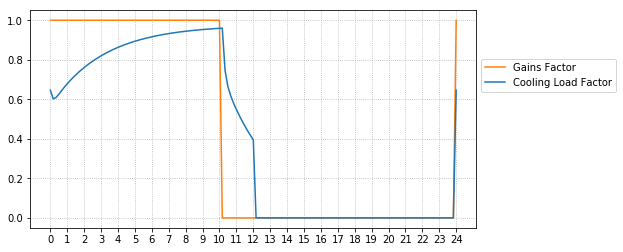

In [34]:
%matplotlib inline
plt.figure(figsize = (8,4))
plt.xticks(np.arange(0, dfl['hour_per'].values[-1] + 1 , 1))
plt.plot(dfl['hour_per'], dfl['GF'], color= 'C1', label="Gains Factor" )
plt.plot(dfl['hour_per'], dfl['CLF'], color= 'C0', label="Cooling Load Factor" )
plt.legend(bbox_to_anchor=(1, 0.8))
plt.grid(linestyle= 'dotted')

In [35]:
dfl['inthour']= dfl['hour'].astype(int)
dfl = dfl.loc[dfl['hour'] == dfl['inthour']]
dfl['hour_per'] = dfl['hour_per'].astype(int)
dfl.index = dfl['hour_per']
dfl = dfl.drop(['tau'], axis=1)
dfl = dfl.drop(['hour'], axis=1)
dfl = dfl.drop(['inthour'], axis=1)
dfl = dfl.drop(['hour_per'], axis=1)
dfl = dfl.drop(['GF'], axis=1)

In [36]:
dfl['CLF'] = round(dfl['CLF'],2)
pd.options.display.max_columns = 999
dfl.T

hour_per,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
CLF,0.65,0.68,0.76,0.82,0.86,0.89,0.92,0.93,0.94,0.95,0.96,0.55,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.65


In [37]:
print("Maximum Cooling Load Factor:", round(np.max(f_loads),2))

Maximum Cooling Load Factor: 0.96
